<a href="https://colab.research.google.com/github/beyzaturku/Weather_Detection_Using_CNN/blob/main/Weather_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conv2D giriş filtresi 128 nöron yapıldı, epoch sayısı 50 yapıldı. **
** test accruacy: 92 **

In [1]:
!python --version

Python 3.11.11


In [2]:
!pip install opencv-python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/Weather_Detection/wd_dataset.zip'

In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

Google Colab'a dosya yükleme işlemi

In [15]:
from google.colab import files
uploaded = files.upload()

Saving wd_dataset.zip to wd_dataset.zip


In [39]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax

Veri Setini Yükleme

In [56]:
image_folder = "Multi-class Weather Dataset"

In [57]:
subfolders = [ 'Cloudy', 'Rain', 'Shine', 'Sunrise']
label_map = { subfolder: idx for idx, subfolder in enumerate(subfolders)}

# List of Images and Labels
images = []
labels = []

# Loading Dataset

for subfolder in subfolders:
    subfolder_path = os.path.join(image_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224,224))
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Coverted to Numpy Arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the Images
images = images.astype('float32') / 255.0

Bazı Rastgele Örnekler

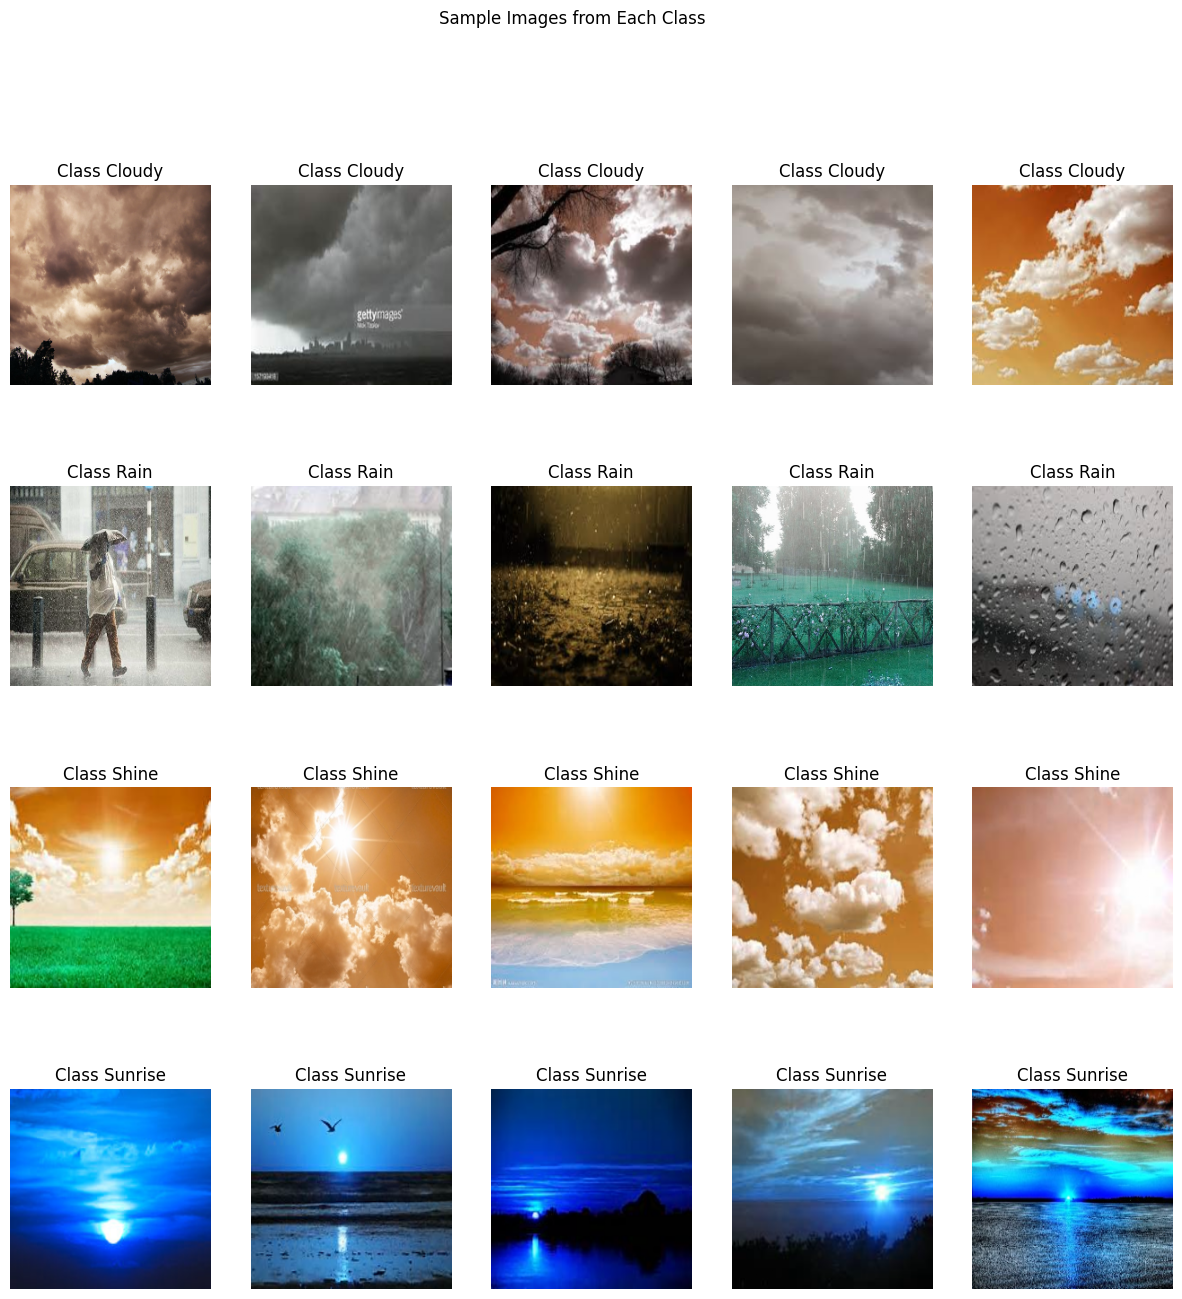

In [58]:
# Plot 5 images from each class
plt.figure(figsize = (15,15))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i*5 + j +1)
        plt.imshow(images[class_indices[j]])
        plt.title(f"Class {subfolder}")
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

Veri Görselleştirme

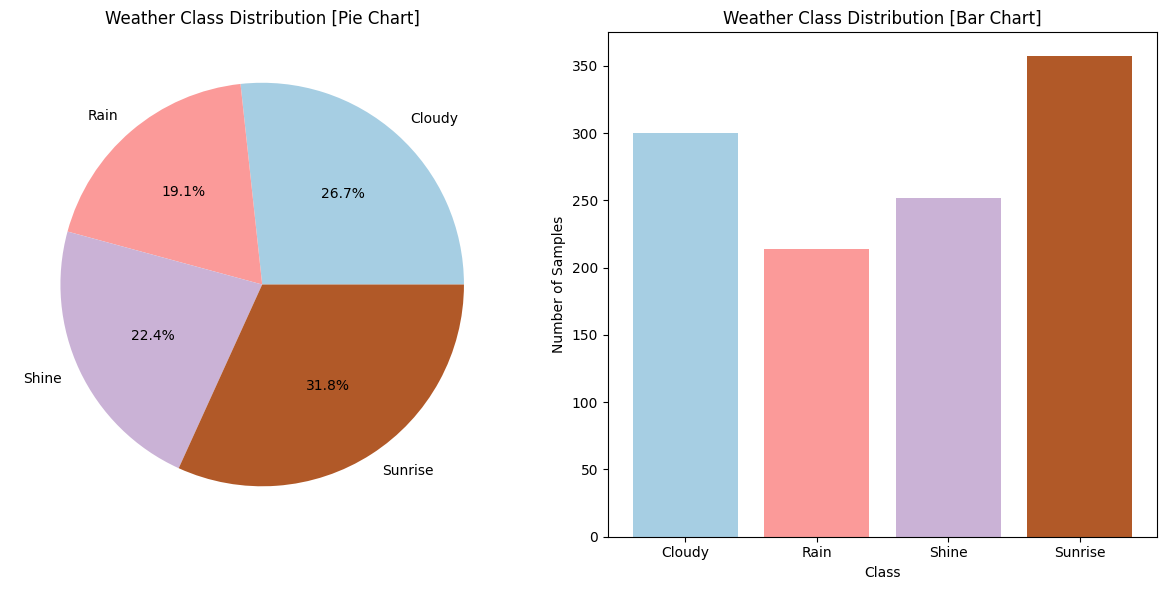

In [59]:
# Visual Representation for Class Distribution [ Pie Chart, Bar Chart]

class_counts = np.bincount(labels)
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
colors = plt.cm.Paired(np.linspace(0, 1, len(class_counts)))
plt.pie(class_counts, labels = subfolders, autopct = '%1.1f%%', colors = colors)
plt.title( 'Weather Class Distribution [Pie Chart]')

plt.subplot(1,2,2)
colors = plt.cm.Paired(np.linspace(0, 1, len(class_counts)))
plt.bar(subfolders, class_counts, color = colors)
plt.title('Weather Class Distribution [Bar Chart]')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

In [60]:
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes = len(subfolders))

Veri Setini Bölme

In [61]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size = 0.2, stratify = labels_one_hot, random_state = 42)

Model Mimarisi - Basit CNN

In [62]:
model = Sequential([
    Conv2D(128, (3,3), activation ='relu', input_shape = (224,224,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25), # overfitting engellemek için dropout kullanılır.
    Conv2D(128, (3,3), activation ='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3,3), activation ='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.1),
    Dense(4, activation = 'softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,374,980 (43.39 MB)

 Trainable params: 11,374,980 (43.39 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(optimizer = Adamax(),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Model Eğitimi

In [64]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.3727 - loss: 2.6437 - val_accuracy: 0.5867 - val_loss: 0.8097
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.6919 - loss: 0.8020 - val_accuracy: 0.7467 - val_loss: 0.6693
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7201 - loss: 0.6782 - val_accuracy: 0.7867 - val_loss: 0.6815
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7771 - loss: 0.5814 - val_accuracy: 0.8444 - val_loss: 0.4889
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8182 - loss: 0.4921 - val_accuracy: 0.7778 - val_loss: 0.5504
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7958 - loss: 0.5382 - val_accuracy: 0.8578 - val_loss: 0.4270
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.8623 - loss: 0.3812 - val_accuracy: 0.7911 - val_loss: 0.4975
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8465 - loss: 0.3931 - val_accuracy: 

Model Değerlendirmesi

In [65]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9166 - loss: 0.2450
Test accuracy: 0.9200000166893005
Test loss: 0.21258236467838287


In [66]:
# Classification Report

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
              precision    recall  f1-score   support

      Cloudy       0.93      0.90      0.92        60
        Rain       0.86      0.98      0.91        43
       Shine       0.89      0.80      0.84        50
     Sunrise       0.97      0.99      0.98        72

    accuracy                           0.92       225
   macro avg       0.91      0.92      0.91       225
weighted avg       0.92      0.92      0.92       225



Karışıklık Matrisi

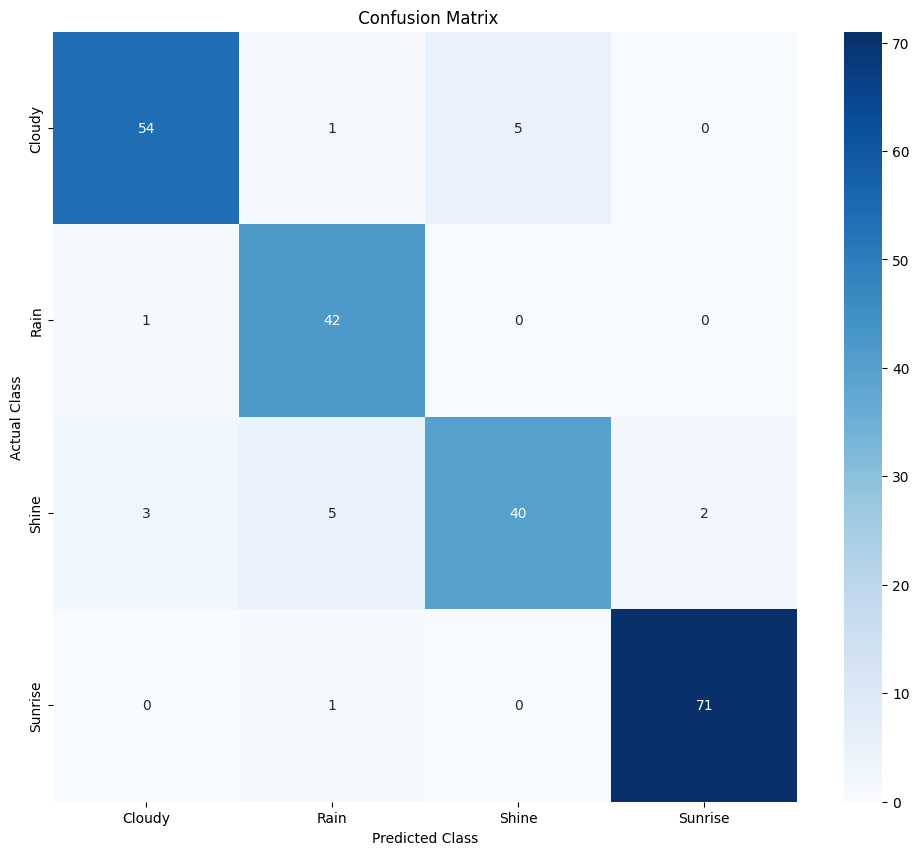

In [67]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,10))
sns.heatmap(conf_mat , annot =True, fmt = 'd', cmap = 'Blues', xticklabels = subfolders, yticklabels = subfolders)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

Bazı Rastgele Tahmin Çalışmaları

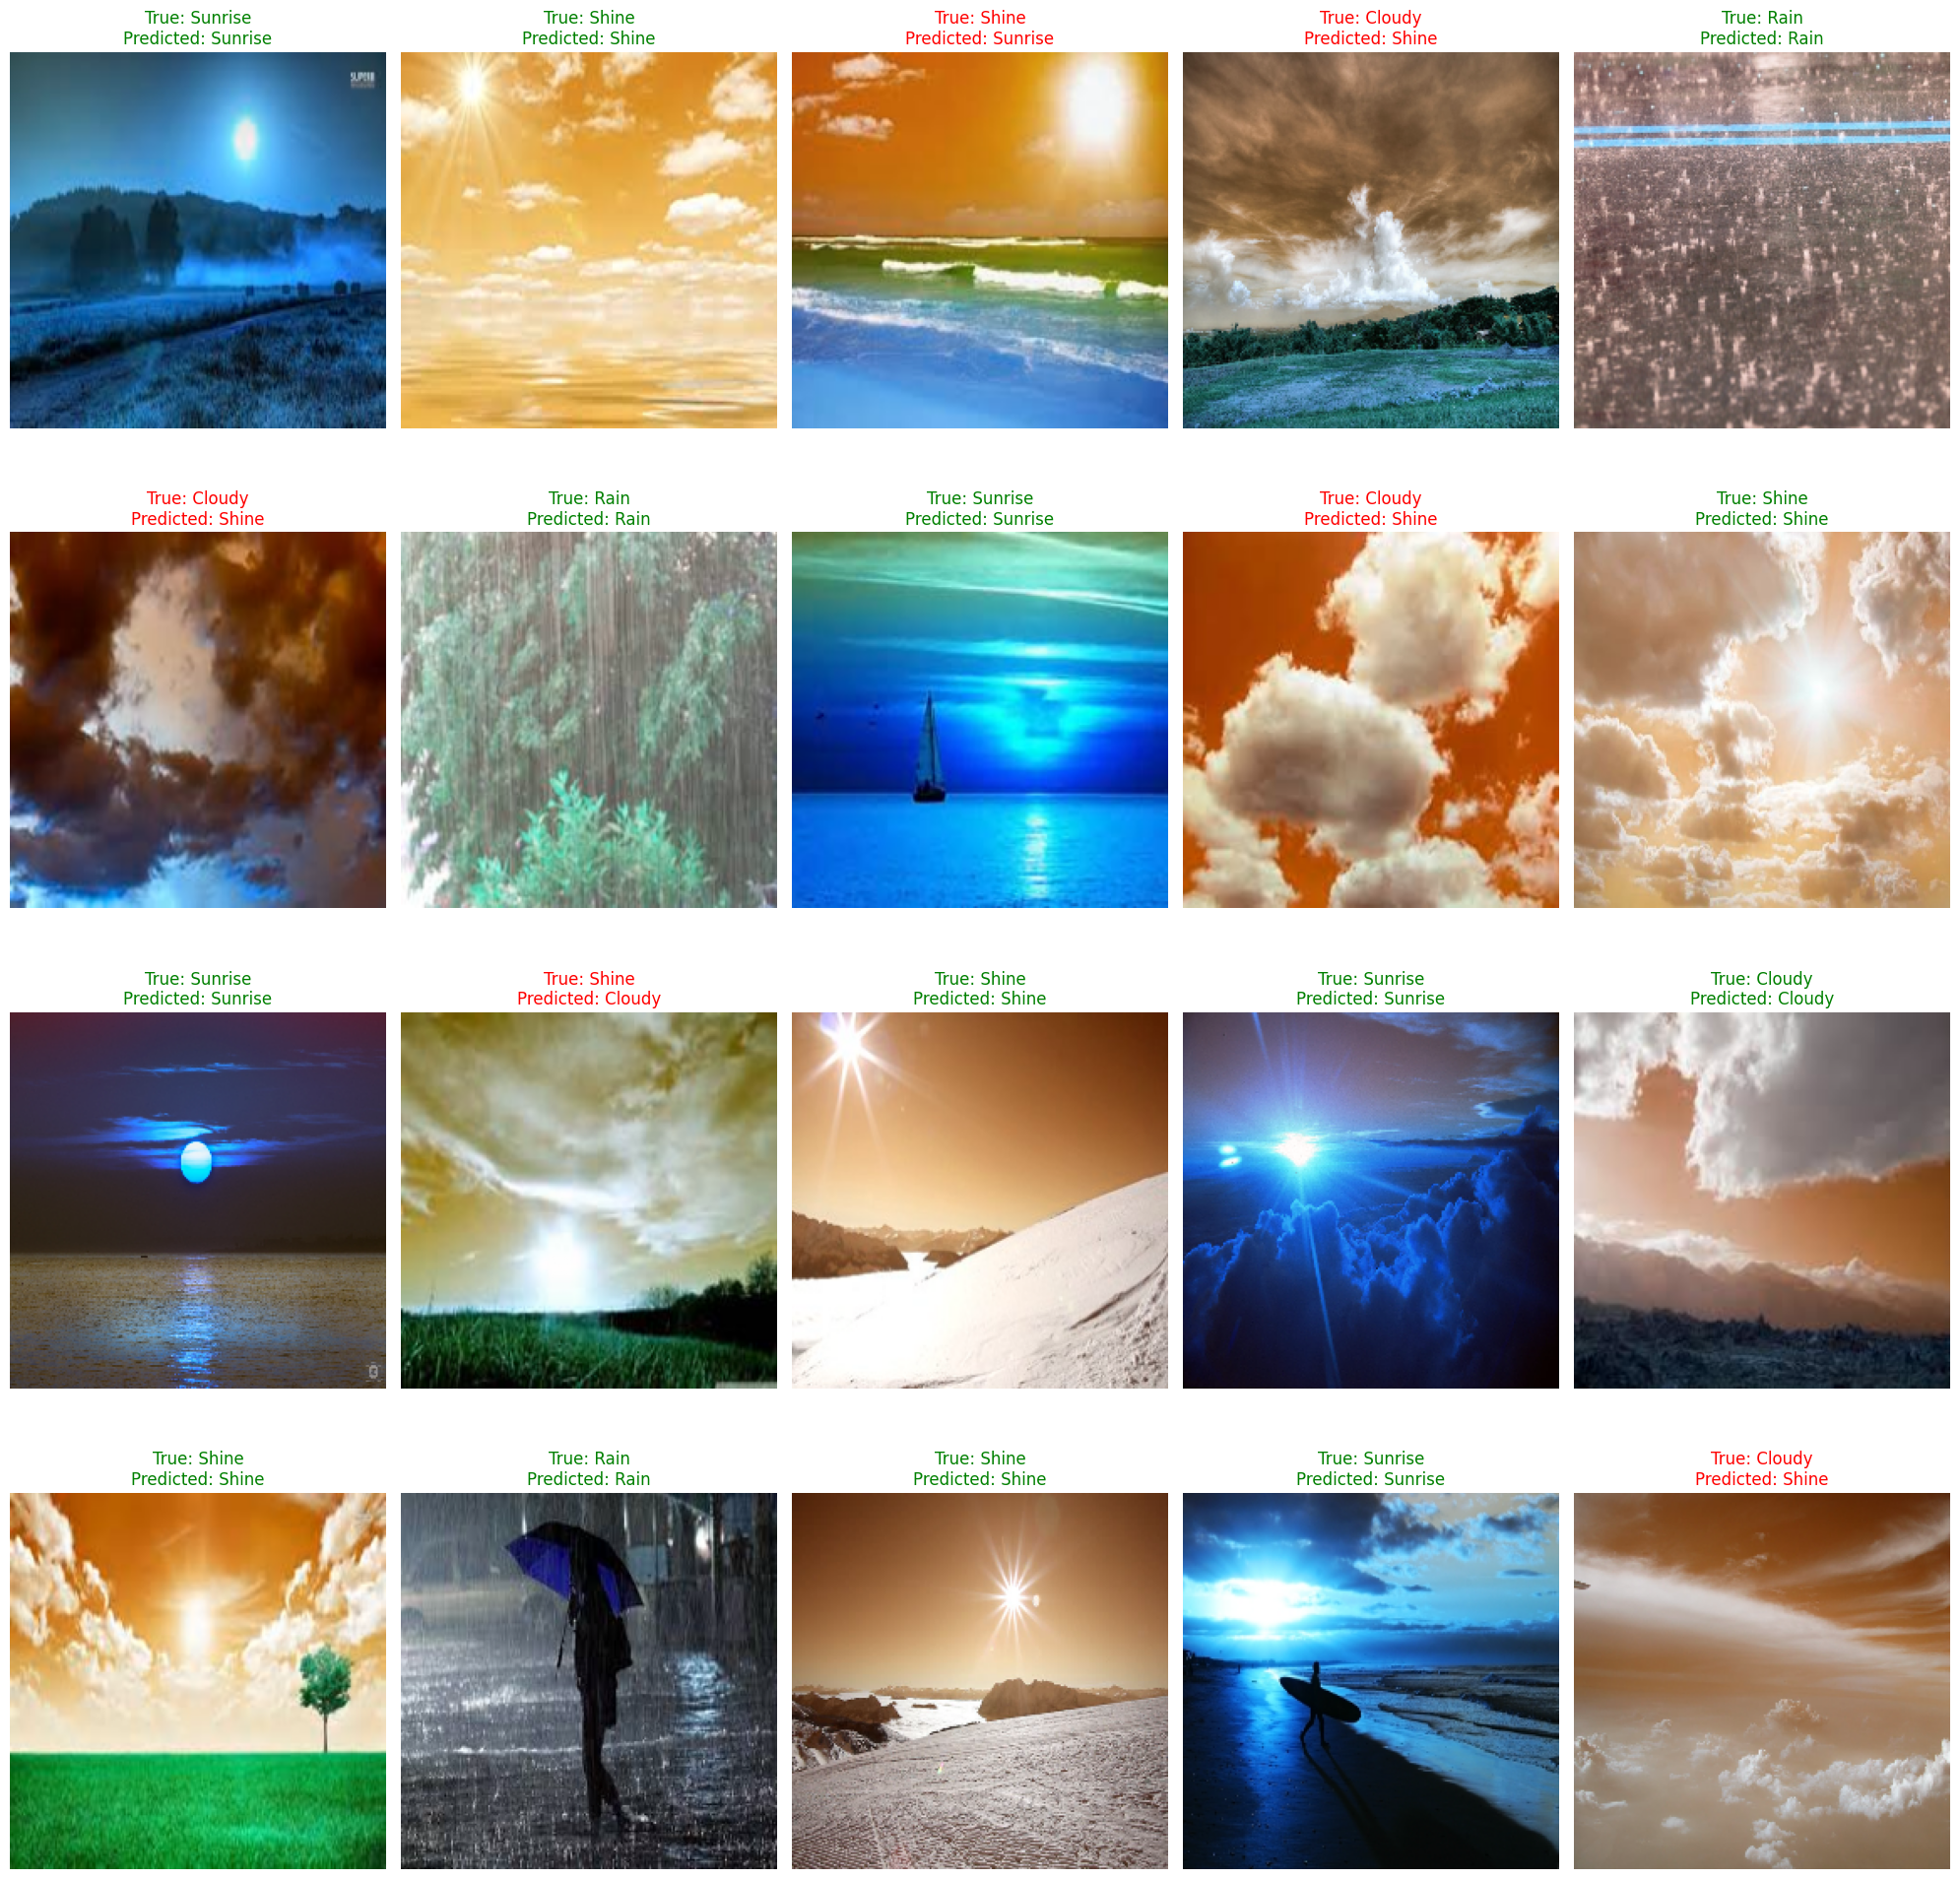

In [69]:
import random

num_samples = 20
rows = 4
wrong_predictions_indices =[]
for idx, (true_label, predicted_label) in enumerate(zip(y_true, y_pred)):
    if true_label != predicted_label:
        wrong_predictions_indices.append(idx)

random_indices = random.sample(range(len(X_test)), num_samples - rows)
random_wrong_indices = random.sample(wrong_predictions_indices, 4)
random_indices.extend(random_wrong_indices)
random_indices = sorted(random_indices)

plt.figure(figsize=(20, 20))
for i, idx in enumerate(random_indices):
    plt.subplot(rows, int(num_samples / rows), i + 1)
    plt.imshow(X_test[idx])
    true_label = y_true[idx]
    true_class = subfolders[true_label]
    predicted_class = subfolders[y_pred[idx]]

    # color-code the correct predictions
    if true_class == predicted_class:
        predicted_color = 'green'
    else:
        predicted_color = 'red'
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}', color=predicted_color)
    plt.axis('off')

plt.tight_layout()
plt.show()